Epoch 1/100


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 3.3200 - val_loss: 2.9997 - learning_rate: 0.0010
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9018 - val_loss: 2.6616 - learning_rate: 0.0010
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.5655 - val_loss: 2.3646 - learning_rate: 0.0010
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2566 - val_loss: 2.1014 - learning_rate: 0.0010
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.0061 - val_loss: 1.8726 - learning_rate: 0.0010
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.8146 - val_loss: 1.6744 - learning_rate: 0.0010
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6239 - val_loss: 1.5049 - learning_rate: 0.0010
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4371 - val_loss: 1.3580 - learning_rate: 0.0010
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2878 - val_loss: 1.2319 - learning_rate: 0.0010
Epoch 10/100
13/13 ━━━━━━━━━━

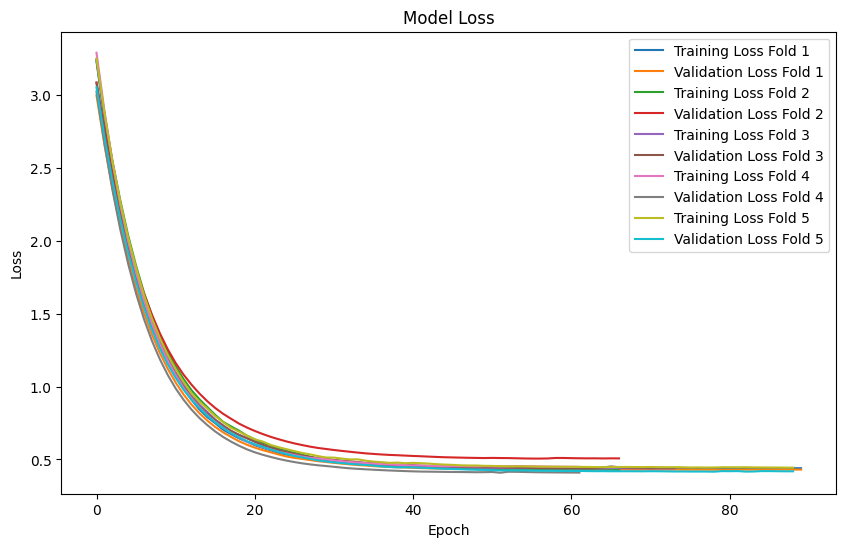

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


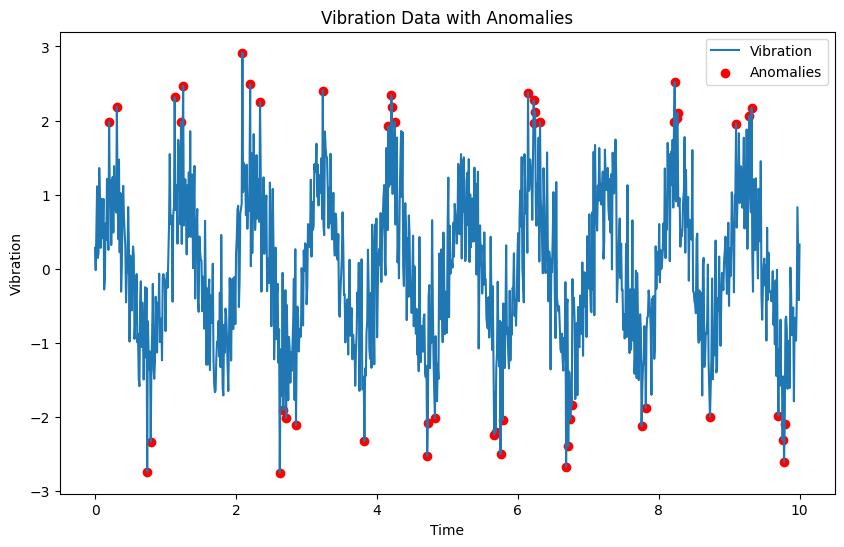

In [2]:
import numpy as np
import pandas as pd
from scipy.fftpack import fft
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from sklearn.model_selection import KFold

# Load the data
data = pd.read_csv('washing_machine_data.csv')

# Normalize the data
data['vibration'] = (data['vibration'] - data['vibration'].mean()) / data['vibration'].std()

# Ensure the array is properly aligned
vibration_aligned = np.ascontiguousarray(data['vibration'].values)

# Apply Fourier Transform
data['fft'] = np.abs(fft(vibration_aligned))

# Scale the FFT output
data['fft'] = (data['fft'] - data['fft'].mean()) / data['fft'].std()

# Prepare the data for autoencoder
X = data['fft'].values.reshape(-1, 1)
y = data['vibration'].values.reshape(-1, 1)  # Using vibration data as labels

# Data augmentation: Add sophisticated noise to training data
def augment_data(data, noise_factor=0.5):
    noisy_data = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    noisy_data = np.clip(noisy_data, 0., 1.)
    return noisy_data

# Define a function to build autoencoder models
def build_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(128, activation=None, kernel_regularizer=l2(0.01))(input_layer)
    encoder = BatchNormalization()(encoder)
    encoder = LeakyReLU(alpha=0.1)(encoder)
    encoder = Dense(64, activation=None, kernel_regularizer=l2(0.01))(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = LeakyReLU(alpha=0.1)(encoder)
    encoder = Dense(32, activation=None, kernel_regularizer=l2(0.01))(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = LeakyReLU(alpha=0.1)(encoder)
    dropout_layer = Dropout(0.5)(encoder)

    decoder = Dense(32, activation=None, kernel_regularizer=l2(0.01))(dropout_layer)
    decoder = BatchNormalization()(decoder)
    decoder = LeakyReLU(alpha=0.1)(decoder)
    decoder = Dense(64, activation=None, kernel_regularizer=l2(0.01))(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = LeakyReLU(alpha=0.1)(decoder)
    decoder = Dense(128, activation=None, kernel_regularizer=l2(0.01))(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = LeakyReLU(alpha=0.1)(decoder)
    output_layer = Dense(input_dim, activation='sigmoid')(decoder)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    return autoencoder

# Define KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store results
training_mse = []
validation_mse = []
histories = []
autoencoders = []

# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train_noisy = augment_data(X_train, noise_factor=0.5)
    
    autoencoder = build_autoencoder(X_train.shape[1])
    optimizer = Adam(learning_rate=0.001, clipvalue=1.0)  # Gradient clipping
    autoencoder.compile(optimizer=optimizer, loss=Huber())
    autoencoders.append(autoencoder)
    
    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
    
    # Train the model
    history = autoencoder.fit(X_train_noisy, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test),
                              callbacks=[early_stopping, reduce_lr], verbose=1)
    histories.append(history)
    
    # Evaluate the model
    train_mse = np.mean(np.power(y_train - autoencoder.predict(X_train), 2))
    val_mse = np.mean(np.power(y_test - autoencoder.predict(X_test), 2))
    
    training_mse.append(train_mse)
    validation_mse.append(val_mse)

# Print the Mean Squared Error
print(f'Mean Squared Error (Training): {np.mean(training_mse)}')
print(f'Mean Squared Error (Validation): {np.mean(validation_mse)}')

# Plot the training and validation loss for the cross-validation
plt.figure(figsize=(10, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Training Loss Fold {i+1}')
    plt.plot(history.history['val_loss'], label=f'Validation Loss Fold {i+1}')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Use the best model from cross-validation to detect anomalies
best_autoencoder = autoencoders[0]  # Assume the first model is the best for simplicity
X_pred = best_autoencoder.predict(X)
mse_all = np.mean(np.power(y - X_pred, 2), axis=1)
threshold = np.percentile(mse_all, 95)
anomalies = mse_all > threshold

# Plot anomalies on the vibration data
plt.figure(figsize=(10, 6))
plt.plot(data['time'], data['vibration'], label='Vibration')
plt.scatter(data['time'][anomalies], data['vibration'][anomalies], color='r', label='Anomalies')
plt.title('Vibration Data with Anomalies')
plt.xlabel('Time')
plt.ylabel('Vibration')
plt.legend()
plt.show()
